## Imports

In [24]:
import pyxdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lmfit.models import ExponentialModel, Model

## Function Definitions

Predicted pupil dilation, $d(Y)$, caused by luminance $Y$, is computed with the following equation: $𝑑(𝑌) = 𝑎 · 𝑒^{−𝑏·𝑌} + c$

In [39]:
def pupil_func(x, a, b, c):
    return a * np.exp(-b * x) + c

## Load Data

Load the data from the experimental input files for a single participant.

In [15]:
streams, header = pyxdf.load_xdf('./Path_Data/ID_109.xdf')

dfs = {}
for stream in streams:
    stream_name = stream['info']['name'][0]
    stream_channels = {}
    for i, channels in enumerate(stream['info']['desc'][0]['channels'][0]['channel']):
        stream_channels[channels['label'][0]] = i
    stream_data = stream['time_series']
    #example of data layout
    #stream_name: LuminanceStream
    #stream_channels: {'UserID': 0, 'BlockID': 1, 'ModelID': 2, 'MethodID': 3, 'Luminance': 4}
    #stream_data: [[1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02]
    data_dict= {}
    for key in stream_channels.keys():
        data_dict[key] = np.array(stream_data)[:, stream_channels[key]]
    time_stamps = np.array(stream['time_stamps'])
    for i in range(len(time_stamps)):
        time_stamps[i] = round(time_stamps[i], 4)
    data_dict['time'] = time_stamps
    dfs[stream_name] = pd.DataFrame(data_dict)
    dfs[stream_name].drop_duplicates(subset=['time'], keep='first', inplace=True)
    dfs[stream_name].reset_index(drop=True, inplace=True)

In [46]:
gaze = dfs['GazeStream']
luminance = dfs['LuminanceStream']
stimulus_events = dfs['ExperimentStream']

calibration_events = stimulus_events.loc[(stimulus_events['EventType'] == 'CalibrationColorChange') | (stimulus_events['SceneEvent'] == 'Calibration'), ['time','SceneEvent', 'EventType']]
calibration_events.reset_index(drop=True, inplace=True)
start_time = calibration_events.loc[0, 'time']

pupil_calib_d = gaze.loc[(gaze['MethodID']>98.0) & (gaze['LeftEyeIsBlinking']==0) & (gaze['RightEyeIsBlinking']==0) & (gaze['LeftPupilDiameter']>0) & (gaze['RightPupilDiameter']>0), ['time', 'LeftPupilDiameter', 'RightPupilDiameter']]
pupil_calib_d.reset_index(drop=True, inplace=True)
lum_calib = luminance.loc[(luminance['MethodID']>98.0), ['time', 'Luminance']]
lum_calib.reset_index(drop=True, inplace=True)

gaze_luminance_time = np.intersect1d(pupil_calib_d['time'], lum_calib['time'])
pupil_calib_d = pupil_calib_d[pupil_calib_d['time'].isin(gaze_luminance_time)]
lum_calib = lum_calib[lum_calib['time'].isin(gaze_luminance_time)]
pupil_calib_d.reset_index(drop=True, inplace=True)
lum_calib.reset_index(drop=True, inplace=True)

pupil_lookup_data = gaze.loc[(gaze['LeftEyeIsBlinking']==0) & (gaze['RightEyeIsBlinking']==0) & (gaze['LeftPupilDiameter']>0) & (gaze['RightPupilDiameter']>0), ['time', 'LeftPupilDiameter', 'RightPupilDiameter']]
pupil_lookup_data.reset_index(drop=True, inplace=True)
lum_lookup_data = luminance.loc[:, ['time', 'Luminance']]
lum_lookup_data.reset_index(drop=True, inplace=True)

gaze_luminance_lookup_time = np.intersect1d(pupil_lookup_data['time'], lum_lookup_data['time'])
pupil_lookup_data = pupil_lookup_data[pupil_lookup_data['time'].isin(gaze_luminance_lookup_time)]
lum_lookup_data = lum_lookup_data[lum_lookup_data['time'].isin(gaze_luminance_lookup_time)]
pupil_lookup_data.reset_index(drop=True, inplace=True)
lum_lookup_data.reset_index(drop=True, inplace=True)

lookup_luminance_pupil_data = pd.DataFrame()
lookup_luminance_pupil_data['time'] = pd.to_timedelta(lum_lookup_data['time'] - lum_lookup_data['time'][0], unit='s')
lookup_luminance_pupil_data['Luminance'] = lum_lookup_data['Luminance']
lookup_luminance_pupil_data['pupilDiameter'] = 0.5 * (pupil_lookup_data['LeftPupilDiameter'] + pupil_lookup_data['RightPupilDiameter'])
lookup_luminance_pupil_data.resample('0.1s', on='time', ).mean()

,Luminance,pupilDiameter
time,,
0 days 00:00:00,0.205574,4.307984
0 days 00:00:00.100000,0.205574,4.370455
0 days 00:00:00.200000,0.205574,4.246401
0 days 00:00:00.300000,0.205574,3.753500
0 days 00:00:00.400000,0.205574,3.449190
...,...,...
0 days 00:22:58.400000,0.142088,3.298693
0 days 00:22:58.500000,0.129057,3.344554
0 days 00:22:58.600000,0.113750,3.355147


In [37]:
luminance_pupil_diameter = pd.DataFrame()
luminance_pupil_diameter['time'] = lum_calib['time']# //pd.to_timedelta(lum_calib['time'] - start_time, unit='s')
luminance_pupil_diameter['Luminance'] = lum_calib['Luminance']
luminance_pupil_diameter['pupilDiameter'] = 0.5 * (pupil_calib_d['LeftPupilDiameter'] + pupil_calib_d['RightPupilDiameter'])

color_data = {}
color_data[0] = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[0, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[1, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color_data[1] = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[1, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[2, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color_data[2] = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[2, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[3, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color_data[3] = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[3, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[4, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color_data[4] = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[4, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[5, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color_data[5] = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[5, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[6, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color_data[6] = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[6, 'time']) & (luminance_pupil_diameter['time']<=calibration_events.loc[7, 'time']), ['time', 'Luminance', 'pupilDiameter']]
color_data[7] = luminance_pupil_diameter.loc[(luminance_pupil_diameter['time']>=calibration_events.loc[7, 'time']), ['time', 'Luminance', 'pupilDiameter']]

for i in range(8):
    color_data[i].reset_index(drop=True, inplace=True)
    color_data[i]['time'] = color_data[i]['time'] - color_data[i]['time'][0]
    color_data[i]=color_data[i].loc[(color_data[i]['time']>=0.5), ['time', 'Luminance', 'pupilDiameter']]
    color_data[i].reset_index(drop=True, inplace=True)

time = []
lum = []
pupd = []
time2 = []
lum2 = []
pupd2 = []
for i in range(8):
    time.append(color_data[i]['time'].mean())
    lum.append(color_data[i]['Luminance'].mean())
    pupd.append(color_data[i]['pupilDiameter'].mean())
    for j in range(len(color_data[i])):
        time2.append(color_data[i]['time'][j])
        lum2.append(color_data[i]['Luminance'][j])
        pupd2.append(color_data[i]['pupilDiameter'][j])

calibration_data = pd.DataFrame()
calibration_data['Luminance'] = lum
calibration_data['PupilDiameter'] = pupd
calibration_data.sort_values(by=['Luminance'], inplace=True)
calibration_data.reset_index(drop=True, inplace=True)


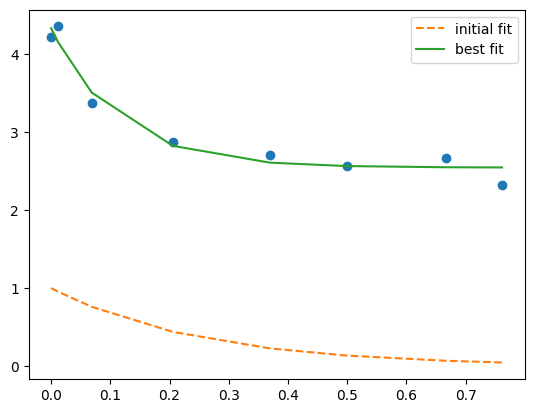

In [45]:
#𝑎, 𝑏, and 𝑐 were fitted using least squares optimization with empirically determined bounds of a: [1, 4], b: [4, 8], and c: [0, 8]
x_data = calibration_data['Luminance']
y_data = calibration_data['PupilDiameter']

exp_mod = Model(pupil_func)
params = exp_mod.make_params(a=1, b=4, c=0)

result = exp_mod.fit(y_data, params, x=x_data)
a = result.params['a'].value
b = result.params['b'].value
c = result.params['c'].value

plt.plot(x_data, y_data, 'o')
plt.plot(x_data, result.init_fit, '--', label='initial fit')
plt.plot(x_data, result.best_fit, '-', label='best fit')
plt.legend()
plt.show()

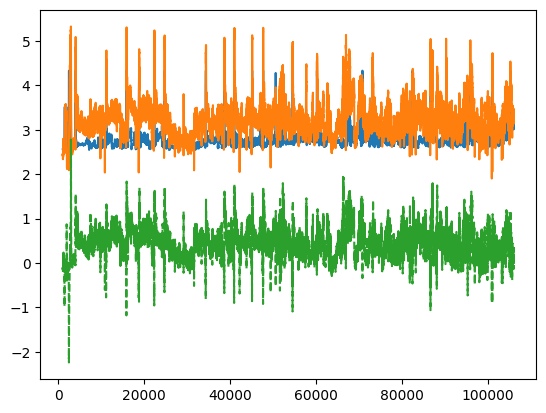

In [64]:
start = 1000
plot_x = lookup_luminance_pupil_data[start:]['Luminance']
predicted_plr = pupil_func(plot_x, a, b, c)

plot_dif = lookup_luminance_pupil_data[start:]['pupilDiameter'] - predicted_plr

plt.plot(lookup_luminance_pupil_data.index[start:], predicted_plr, '-', label='predicted')
plt.plot(lookup_luminance_pupil_data.index[start:], lookup_luminance_pupil_data[start:]['pupilDiameter'], '-', label='actual')
plt.plot(lookup_luminance_pupil_data.index[start:], plot_dif, '--', label='difference')
